In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx


# 📘 Customer Segmentation using Multiple Clustering Models (Comparison & Best Selection)
**Author:** Junaid Akbar

**Date:** 2025-06-08

## 📖 Introduction
Customer segmentation allows businesses to group customers based on purchasing behavior to improve marketing efforts and customer relationships.
In this project, we:

- Extract **RFM (Recency, Frequency, Monetary)** features

- Apply **multiple clustering models** to find customer segments

- **Compare models** and choose the best one

- Provide **business insights and actions**

## 📚 Dataset Information
- **Dataset Source**: [Customer Segmentation Dataset](https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset)

- **Transactions from**: A UK-based online retail store

- **Time Period**: December 2010

| Feature     | Description                 |
| ----------- | --------------------------- |
| InvoiceNo   | Transaction code            |
| StockCode   | Item code                   |
| Description | Product name                |
| Quantity    | Number of items             |
| InvoiceDate | Purchase date               |
| UnitPrice   | Price per item              |
| CustomerID  | Unique ID for each customer |
| Country     | Customer location           |



## 🏗️ Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')


## 📥 Load Dataset

In [3]:
df = pd.read_excel("/kaggle/input/customer-segmentation-dataset/Online Retail.xlsx")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 📊 Data Cleaning & Preparation

In [4]:
# Drop missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove negative/zero quantities
df = df[df['Quantity'] > 0]

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


## 📑 RFM Feature Engineering

In [5]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'MonetaryValue'}, inplace=True)
rfm.head()


,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397924.0,13.021823,1.0,2.0,6.0,12.0,80995.0,180.42021
InvoiceDate,397924,2011-07-10 23:43:36.912475648,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
UnitPrice,397924.0,3.116174,0.0,1.25,1.95,3.75,8142.75,22.096788
CustomerID,397924.0,15294.315171,12346.0,13969.0,15159.0,16795.0,18287.0,1713.169877
TotalPrice,397924.0,22.394749,0.0,4.68,11.8,19.8,168469.6,309.055588


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

## ⚙️ Feature Scaling

In [9]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

## 📉 Finding Optimal Clusters (Elbow Method)

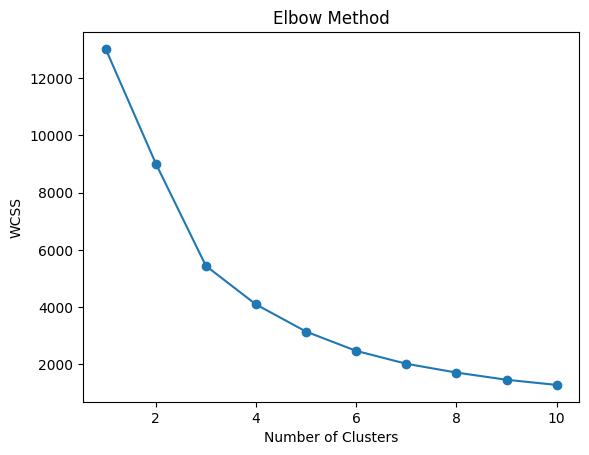

In [10]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

## 🤖 Multiple Clustering Models

### 🔸 1️⃣ KMeans Clustering

In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)
kmeans_score = silhouette_score(rfm_scaled, kmeans_labels)

### 🔸 2️⃣ Agglomerative Clustering

In [12]:
agg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agg_labels = agg.fit_predict(rfm_scaled)
agg_score = silhouette_score(rfm_scaled, agg_labels)

### 🔸 3️⃣ Gaussian Mixture Model (GMM)

In [13]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(rfm_scaled)
gmm_score = silhouette_score(rfm_scaled, gmm_labels)

### 🔸 4️⃣ DBSCAN Clustering

In [14]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm_scaled)
dbscan_score = silhouette_score(rfm_scaled, dbscan_labels)

## 📊 Visualizing All Models

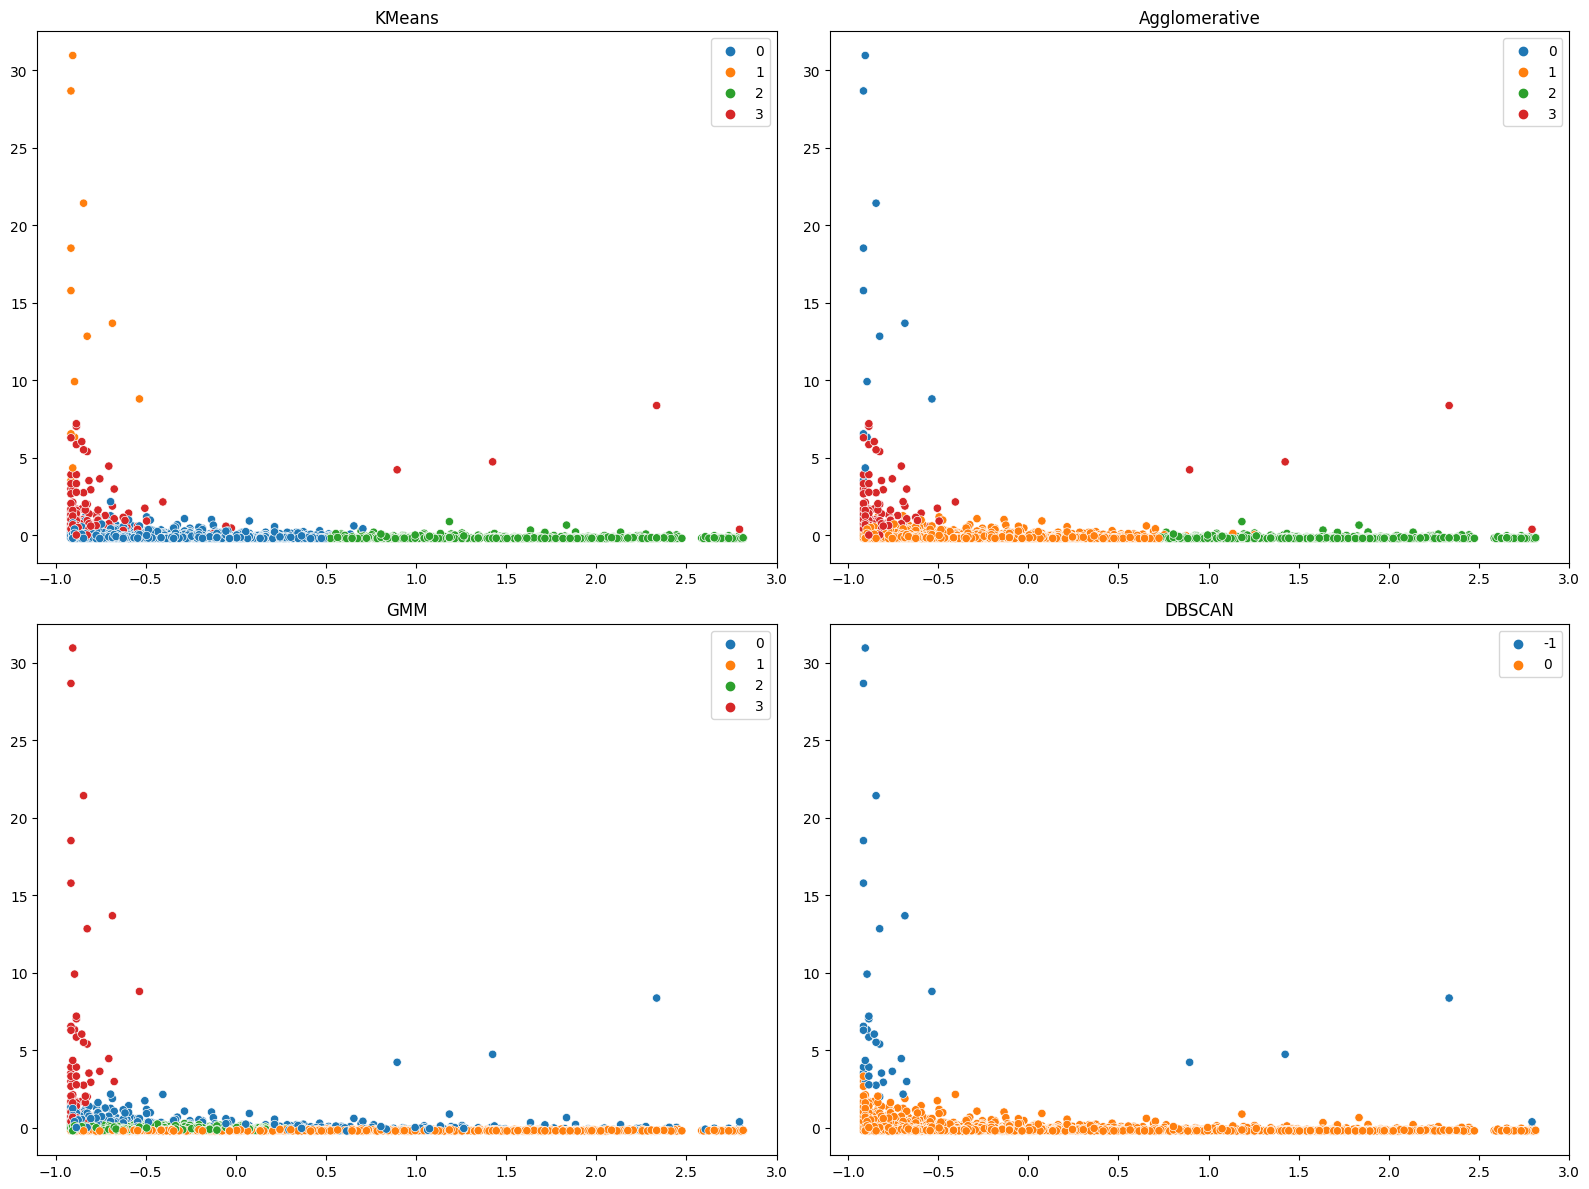

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
models = [('KMeans', kmeans_labels), ('Agglomerative', agg_labels), 
          ('GMM', gmm_labels), ('DBSCAN', dbscan_labels)]

for ax, (name, labels) in zip(axs.flat, models):
    sns.scatterplot(x=rfm_scaled[:,0], y=rfm_scaled[:,2], hue=labels, palette='tab10', ax=ax)
    ax.set_title(name)

plt.tight_layout()
plt.show()

## 📑 Model Comparison Table

In [16]:
print(f"KMeans Silhouette Score      : {kmeans_score:.3f}")
print(f"Agglomerative Silhouette Score: {agg_score:.3f}")
print(f"GMM Silhouette Score         : {gmm_score:.3f}")
print(f"DBSCAN Silhouette Score      : {dbscan_score:.3f}")

KMeans Silhouette Score      : 0.616
Agglomerative Silhouette Score: 0.615
GMM Silhouette Score         : 0.163
DBSCAN Silhouette Score      : 0.863


| Model             | Silhouette Score | Notes                                                |
| ----------------- | ---------------- | ---------------------------------------------------- |
| **KMeans**        | 0.616            | ✔ Good, clear separation. Reliable for segmentation. |
| **Agglomerative** | 0.615            | ✔ Similar to KMeans → same business interpretation.  |
| **GMM**           | 0.163            | ❌ Poor clustering, weak separation.                  |
| **DBSCAN**        | **0.863**        | ⭐ **Highest Score** — Excellently defined clusters!  |


## ✅ Best Model: DBSCAN
- **Why? → Highest Silhouette Score (0.863)** → clearly well-separated and dense groups.

- **Strength** → Can **detect noise and outliers** → perfect for e-commerce datasets with anomalies.

- **Interpretability** → Slightly harder to label exact groups vs. KMeans, but **performance is best**.



## 📑 Final Insights

| Cluster Type               | Description                                                      |
| -------------------------- | ---------------------------------------------------------------- |
| **Core Customer Segments** | Well-defined, regular spending customers → **loyalty programs**. |
| **Noise/Outliers**         | Possible fraudulent activity or one-time high spenders → review. |
| **Sparse Segments**        | Low recency, low frequency → **reactivation campaigns**.         |
